# This notebook performs the partition between AMOC and gyre heat transport at 26N. You must run the notebook multiple times to find this for each ensemble member. 

In [1]:
# Set up a cluster using dask
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(20)
cluster

In [2]:
#Make a client so you can see the progress of tasks (click the link that appears below)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e8ec538041584d04b2cffccedb6d4bf7/status,


# Now load the data

In [3]:
import intake
import pandas as pd
import pprint
import fsspec

import xarray as xr
import xgcm
import numpy as np
import s3fs

import matplotlib.pyplot as plt
%matplotlib inline

from fastjmd95 import jmd95numba
import dask

In [4]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")
col_subset = col.search(experiment="20C",variable=["TEMP", "SALT","PD","UVEL","VVEL","WVEL","SHF","VNT","WTT"])
#col_subset = col.search(experiment="20C",variable=["TEMP"])
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/tmp/ipykernel_2570/1335283246.py:5: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


In [5]:
ds = dsets['ocn.20C.monthly']
theta = ds.TEMP
salt = ds.SALT
uvel = ds.UVEL
vvel = ds.VVEL
wvel = ds.WVEL
vnt = ds.VNT
wtt = ds.WTT
pot_dens = ds.PD

shf = ds.SHF

url = "s3://ncar-cesm-lens/ocn/static/grid.zarr"
fs = s3fs.S3FileSystem(anon=True)
grid_ds = xr.open_zarr(s3fs.S3Map(url, s3=fs))

In [6]:
th0 = theta.roll(nlon=60).sel(nlon=slice(22,110))
slt0 = salt.roll(nlon=60).sel(nlon=slice(22,110))
uvel0 = uvel.roll(nlon=60).sel(nlon=slice(22,110))
vel0 = vvel.roll(nlon=60).sel(nlon=slice(22,110))
wvel0 = wvel.roll(nlon=60).sel(nlon=slice(22,110))
pd0 = pot_dens.roll(nlon=60).sel(nlon=slice(22,110))
#vnt0 = vnt.roll(nlon=60)
#wtt0 = wtt.roll(nlon=60)
shf0 = shf.roll(nlon=60).sel(nlon=slice(22,110))
grid0 = grid_ds.roll(nlon=60,roll_coords=True).sel(nlon=slice(22,110))

uvel0=uvel0.rename({'nlon':'vlon','nlat':'vlat'})
vel0=vel0.rename({'nlon':'vlon','nlat':'vlat'})

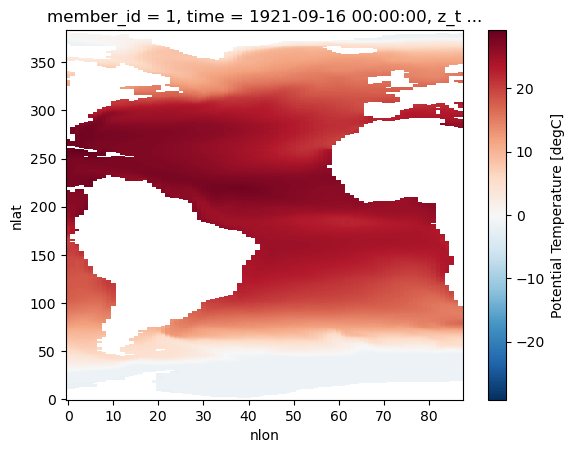

In [7]:
th0.isel(member_id=0).isel(time=20).isel(z_t=1).plot()

In [8]:
#create grid object

#first merge v and w 

pd_jmd1 = jmd95numba.rho(slt0, th0, 1000)

ds = vel0.to_dataset().merge(wvel0)
ds = ds.merge(th0)
#ds = ds.merge(pd_jmd1.rename('JmdPd'))
ds = ds.merge(pd0)
ds = ds.merge(grid0.DXU.rename({'nlon':'vlon','nlat':'vlat'}).rename('gridS'))
z_outer = np.concatenate((ds.z_w_top.values,np.asarray(550000).reshape((-1,))))
ds = ds.assign_coords(z_w_outer=z_outer)

from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

grid = Grid(ds, coords={'X':{'center': 'nlon','right': 'vlon'},'Y':{'center': 'nlat','right': 'vlat'},'Z': {'center': 'z_t','outer': 'z_w_outer'}},periodic=False)

#calculate dz
dz = grid0.dz#.diff(ds.z_w_outer,axis='Z',boundary='extend')

### Now we interpolate and subset the data before moving forward

In [9]:
latit = 270

In [10]:
pick_id = 35
vs = grid.interp(ds.VVEL*ds.gridS,'X',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)
ts = grid.interp(ds.TEMP,'Y',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)
deltaxS = grid.interp(ds.gridS,'X',boundary='fill').sel(vlat=latit)
pdS = grid.interp(ds.PD*1000,'Y',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)
longitude=ds.ULONG.sel(vlat=latit)

In [11]:
#Create a region mask for the Atlantic
atl_mask = grid0.REGION_MASK
atl_mask = atl_mask.where((atl_mask==6) | (atl_mask==8))
atl_mask = atl_mask.where(np.isnan(atl_mask),1)
maskS = atl_mask.rename({'nlat':'vlat'}).sel(vlat=latit)

# Calculate key components

In [12]:
#heat transport
heat_transport = vs*ts

#remove throughflow
vel_mean = (vs*dz*maskS).sum(['nlon','z_t'])/(xr.ones_like(vs).where(np.isfinite(vs))*dz*maskS).sum(['nlon','z_t'])

vel_notf = vs - vel_mean

#mean temp
temp_mean = (ts*deltaxS*dz*maskS).sum(['nlon','z_t'])/(xr.ones_like(vs).where(np.isfinite(vs))*deltaxS*dz*maskS).sum(['nlon','z_t'])

ht_nothroughflow = heat_transport - vel_mean*temp_mean

# Transform into density coords

In [13]:
#pdS = grid.interp(ds.JmdPd,'Y',boundary='fill')


rho_axis1=np.arange(22.5,28.5,0.01)
#rho_axis1=np.concatenate((np.arange(20,27,0.1),np.arange(27,28.1,0.001)))

#transform volume transport into density coords
MOC_jmd1 = grid.transform(vel_notf*dz*maskS/100**3, target = rho_axis1, target_data=(pdS.rename('PD')-1000),#pd_outer.chunk({'z_w_outer': -1}), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

#find the actual MOC
MOC_1 = (MOC_jmd1.sum('nlon').cumsum('PD'))

#transport in member 1
transport_1 = MOC_jmd1

#transform temperature into density coords
ts_1 = grid.transform(ts*dz*maskS/100, target = rho_axis1, target_data=(pdS.rename('PD')-1000),#pd_outer.chunk({'z_w_outer': -1}), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

th_1 = grid.transform(xr.ones_like(ts)*dz*maskS/100, target = rho_axis1, target_data=(pdS.rename('PD')-1000),#pd_outer.chunk({'z_w_outer': -1}), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')



#transform heat transport into density coords
ht_jmd1 = grid.transform(ht_nothroughflow*dz*maskS/100**3, target = rho_axis1, target_data=(pdS.rename('PD')-1000),#pd_outer.chunk({'z_w_outer': -1}), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

ht_1 = ht_jmd1


/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x7a310261bd90>` instead of `Axis.<function raw_interp_function at 0x7a310261bd90>`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/t

In [14]:
#define latitude and time slice

mid=slice(1,10)
timeslice = slice('1940-01-01','2016-02-01')

#define seconds per month
df = pd.DataFrame({'date1':pd.date_range('1940-01-01','2005-12-01',freq='MS'),
                   'date2':pd.date_range('1940-02-01','2006-01-01', freq='MS')})
df['diff'] = df['date2']-df['date1']
dt = df['diff'].dt.total_seconds().to_numpy()
ds_dt = xr.DataArray(dt,coords={'time':ds.TEMP.sel(time=timeslice).time.values},dims=['time'])

In [15]:
#pick a timeslice and use pre-calculated maximum MOC location 

PDloc=527

PDgyre=470

#do a rolling mean to avoid spikes in i*
max_MOC = MOC_1.isel(PD=PDloc)

max_MOC = max_MOC.sel(time=timeslice).rolling(time=24).mean().dropna("time",how='all')

transport_43N = transport_1.sel(time=timeslice).rolling(time=24).mean().dropna("time",how='all')

transport_above = transport_43N.isel(PD=slice(0,PDloc)).sum('PD')

gyre_above = transport_43N.isel(PD=slice(0,PDgyre)).sum('PD')

ht_43N = ht_1.sel(time=timeslice).rolling(time=24).mean().dropna("time",how='all')

ht_above = ht_43N.isel(PD=slice(0,PDloc)).sum('PD')

ht_gabove = ht_43N.isel(PD=slice(0,PDgyre)).sum('PD')

temp_43N = ts_1.sel(time=timeslice).rolling(time=24).mean().dropna("time",how='all')

temp_above = temp_43N.isel(PD=slice(0,PDloc)).sum('PD')

th_43N = th_1.sel(time=timeslice).rolling(time=24).mean().dropna("time",how='all')

thickness_above = th_43N.isel(PD=slice(0,PDloc)).sum('PD')

In [16]:
transport_above.load()

gyre_above.load()

<xarray.DataArray (time: 769, nlon: 88)>
array([[      0.        ,       0.        , 5618076.03914656, ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        , 5639340.8300557 , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        , 5645812.15011014, ...,
              0.        ,       0.        ,       0.        ],
       ...,
       [      0.        ,       0.        , 5604665.34876512, ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        , 5610582.48425995, ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        , 5606994.41098115, ...,
              0.        ,       0.        ,       0.        ]])
Coordinates: (12/53)
    member_id           int64 35
  * time                (time) object 1941-12-16 12:00:00 ... 2005-12-16 12:0...
    T0_Kelvin           float64 273.1
    cp_air              float64 1.005e+03
    cp_sw               float64 3.996e+07
    days_in_norm_year   timedelta64[ns] 365 days
    ...                  ...
    TAREA               (nlon) float64 5.986e+13 5.976e+13 ... 6.122e+13
    TLAT                (nlon) float64 26.2 26.18 26.16 ... 26.44 26.46 26.49
    TLONG               (nlon) float64 278.0 279.1 280.2 ... 13.22 14.34 15.46
    UAREA               (nlon) float64 5.974e+13 5.964e+13 ... 6.123e+13
    ULAT                (nlon) float64 26.43 26.41 26.39 ... 26.69 26.72 26.75
    ULONG               (nlon) float64 278.6 279.7 280.8 ... 13.77 14.89 16.02
Dimensions without coordinates: nlon

In [17]:
gyre_cum = gyre_above.cumsum('nlon')

gyre_sum = gyre_above.sum('nlon')

gmax = gyre_cum.argmax('nlon')
transport_talley = gyre_cum.isel(nlon=gmax) - gyre_sum 

transport_tal_left = transport_43N.isel(nlon=slice(0,gmax[0].values+1)).sum('nlon').cumsum('PD') - transport_talley

transport_tal_base = transport_tal_left.where(lambda x: x>0).idxmin(dim='PD')
transport_tal_base = transport_tal_base.where(transport_tal_base<26.8).ffill('time',limit=4)

In [18]:
#
transport_cum = (transport_above.cumsum('nlon') - transport_above.sum('nlon')).round(5)

transport_masked = xr.ones_like(transport_cum).where(transport_cum>=0)

def find_pos(x):
    y = np.argmax(x>0,axis=1)
    return y.reshape(-1,1)

istar_int = xr.apply_ufunc(find_pos,transport_masked.chunk({"nlon": -1}),input_core_dims=[['nlon']],output_core_dims=[['lonind']],
                       dask='allowed',output_sizes={'lonind':1})
#istar_int.plot()


In [19]:
istar_int.load();

In [20]:
max_MOC.load();

In [21]:
istar_delta = (max_MOC.load() - transport_above.where(transport_above.nlon<istar_int).sum('nlon').load()
              )/(transport_above.where(transport_above.nlon==istar_int).sum('nlon'))

In [22]:
seconds_per_month = 30*24*3600
rho0=1029 
cp=3994
factor = rho0*cp/10**22
factor

4.109826e-16

In [23]:
ht_tf = (vel_mean*temp_mean*dz*maskS/100**3
        ).rolling(time=24).mean().dropna("time",how='all').sel(time=timeslice).sum(['z_t','nlon'])

In [24]:
ht_left = ((ht_above.where(transport_above.nlon<istar_int).sum('nlon')+istar_delta*ht_above.where(transport_above.nlon==istar_int).sum('nlon')))
ht_right = ((ht_above).sum('nlon') - ht_left)
ht_down = (ht_43N.isel(PD=slice(PDloc,1000)).sum('PD')).sum('nlon')
ht_tot = (ht_43N.sum('PD').sum('nlon'))


In [25]:
ht_tal_left = ht_43N.isel(nlon=slice(0,gmax[0].values+1)).where(ht_43N.PD<=transport_tal_base).sum(['PD','nlon'])
ht_tal_right = ht_gabove.isel(nlon=slice(gmax[0].values+1,100)).sum(['nlon'])
ht_tal_gyre = ht_tal_left + ht_tal_right

In [26]:
#zonal method (for comparison)
th_zon_mean = (ts*deltaxS*maskS).sum(['nlon'])/(xr.ones_like(vs).where(np.isfinite(vs))*deltaxS*maskS).sum(['nlon'])
transport_zon_mean = (vel_notf*maskS/100**2).sum(['nlon'])
ht_zon_ot = (transport_zon_mean*th_zon_mean*dz/100).rolling(time=24).mean().dropna("time",how='all').sum('z_t').sel(time=timeslice)
ht_zon_tot = (ht_nothroughflow.rolling(time=24).mean().dropna("time",how='all')*dz*maskS/100**3).sum(['nlon','z_t']).sel(time=timeslice)

In [27]:
#zonal method in buoyancy space (for comparison)
th_bzon_mean = (temp_43N*deltaxS).sum(['nlon'])/(th_43N*deltaxS*maskS).sum(['nlon'])
transport_bzon_mean = (transport_43N).sum(['nlon'])
ht_bzon_ot = (transport_bzon_mean*th_bzon_mean).sum('PD').sel(time=timeslice)
ht_bzon_tot = ht_zon_tot

In [28]:
def detrend_time(cum_ht):
    p=cum_ht.polyfit(dim='time', deg=1)
    fit = xr.polyval(cum_ht.time, p.polyfit_coefficients)
    return cum_ht-fit

In [29]:
import matplotlib.pyplot as plt

(-29220.0, 3653.0)

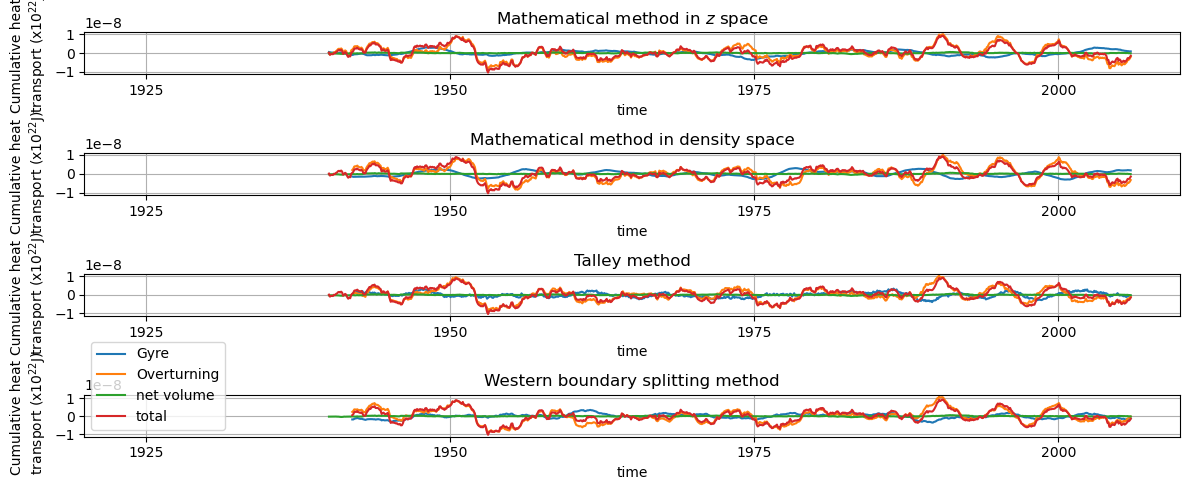

In [30]:
import cftime
plt.figure(figsize=(12,5))
plt.subplot(411)

detrend_time((ht_zon_tot-ht_zon_ot-ht_tf)*factor).plot(label='Gyre')
detrend_time((ht_zon_ot-ht_tf)*factor).plot(label='Overturning')
detrend_time(ht_tf*factor).plot(label='net volume')
detrend_time(ht_zon_tot*factor).plot(label='total')
plt.title('Mathematical method in $z$ space')

plt.ylabel('Cumulative heat \n transport (x$10^{22}$J)')
plt.grid()
plt.xlim(cftime.datetime(1920,1,1),cftime.datetime(2010,1,1))

plt.subplot(412)
detrend_time((ht_bzon_tot-ht_bzon_ot)*factor).plot(label='Gyre')
detrend_time((ht_bzon_ot)*factor).plot(label='Overturning')
detrend_time(ht_tf*factor).plot(label='net volume')
detrend_time(ht_bzon_tot*factor).plot(label='total')
plt.title('Mathematical method in density space')

plt.ylabel('Cumulative heat \n transport (x$10^{22}$J)')
plt.grid()
plt.xlim(cftime.datetime(1920,1,1),cftime.datetime(2010,1,1))

plt.subplot(413)
detrend_time((ht_tal_gyre)*factor).plot(label='Gyre')
detrend_time((ht_tot - ht_tal_gyre)*factor).plot(label='Overturning')
detrend_time(ht_tf*factor).plot(label='net volume')
detrend_time(ht_zon_tot*factor).plot(label='total')
plt.title('Talley method')

plt.ylabel('Cumulative heat \n transport (x$10^{22}$J)')
plt.grid()
plt.xlim(cftime.datetime(1920,1,1),cftime.datetime(2010,1,1))

plt.subplot(414)
detrend_time(ht_right*factor).plot(label='Gyre')
detrend_time((ht_down+ht_left)*factor).plot(label='Overturning')
detrend_time(ht_tf*factor).plot(label='net volume')
detrend_time(ht_tot*factor).plot(label='total')
plt.legend(loc='lower left')
plt.ylabel('Cumulative heat \n transport (x$10^{22}$J)')
plt.grid()
plt.tight_layout()
plt.title('Western boundary splitting method')
plt.xlim(cftime.datetime(1920,1,1),cftime.datetime(2010,1,1))

#fig = plt.gcf()
#fig.savefig('gyre_ot_ensemble3.png')

In [164]:
long_1 = ((longitude.loc[istar_int-1]+istar_delta*(longitude.loc[istar_int]-longitude.loc[istar_int-1]))-360).squeeze()
long_med = long_1.load().median(dim='time')

mathz_gyre = (ht_zon_tot-ht_zon_ot)*factor
mathz_ot = (ht_zon_ot)*factor
net = ht_tf*factor
tot = ht_zon_tot*factor

mathd_gyre = (ht_bzon_tot-ht_bzon_ot)*factor
mathd_ot = (ht_bzon_ot)*factor

talley_gyre = ht_tal_gyre*factor
talley_ot = (ht_tot - ht_tal_gyre)*factor

west_gyre = (ht_right*factor).squeeze()
west_ot = ((ht_down+ht_left)*factor).squeeze()


meantemp_left = ((temp_above.where(transport_above.nlon<istar_int).sum('nlon')+istar_delta*temp_above.where(transport_above.nlon==istar_int).sum('nlon'))/
                 (thickness_above.where(transport_above.nlon<istar_int).sum('nlon')+istar_delta*thickness_above.where(transport_above.nlon==istar_int).sum('nlon'))).squeeze()
ht_meantemp_left = (meantemp_left*max_MOC)

meantemp_down = ((temp_43N.isel(PD=slice(PDloc,792)).sum('PD').sum('nlon'))/
                 (th_43N.isel(PD=slice(PDloc,792)).sum('PD').sum('nlon')))
ht_meantemp_down = (meantemp_down*max_MOC)

mean_temps_left_r = meantemp_left.mean()
mean_temps_down_r = meantemp_down.mean()

max_MOC_r = max_MOC.mean()

ht_meantemp_left_dv = (mean_temps_left_r*max_MOC)
ht_meantemp_down_dv = (mean_temps_down_r*max_MOC)

ht_meantemp_left_dt = (meantemp_left*max_MOC_r)
ht_meantemp_down_dt = (meantemp_down*max_MOC_r)

ds_ens1 = mathz_gyre.rename('mathz_gyre').to_dataset()
ds_ens1 = ds_ens1.merge(mathz_ot.rename('mathz_ot'))
ds_ens1 = ds_ens1.merge(net.rename('net'))
ds_ens1 = ds_ens1.merge(tot.rename('tot'))
ds_ens1 = ds_ens1.merge(mathd_gyre.rename('mathd_gyre'))
ds_ens1 = ds_ens1.merge(mathd_ot.rename('mathd_ot'))
ds_ens1 = ds_ens1.merge(talley_gyre.rename('talley_gyre'))
ds_ens1 = ds_ens1.merge(talley_ot.rename('talley_ot'))

ds_ens1 = ds_ens1.merge(west_gyre.rename('west_gyre'))
ds_ens1 = ds_ens1.merge(west_ot.rename('west_ot'))
ds_ens1 = ds_ens1.merge(meantemp_left.rename('meantemp_left'))

ds_ens1 = ds_ens1.merge(ht_left.rename('ht_left'))
ds_ens1 = ds_ens1.merge(ht_down.rename('ht_down'))


ds_ens1 = ds_ens1.merge(ht_meantemp_left.rename('ht_meantemp_left'))
ds_ens1 = ds_ens1.merge(meantemp_down.rename('meantemp_down'))
ds_ens1 = ds_ens1.merge(ht_meantemp_down.rename('ht_meantemp_down'))
ds_ens1 = ds_ens1.merge(ht_meantemp_left_dv.rename('ht_meantemp_left_dv'))
ds_ens1 = ds_ens1.merge(ht_meantemp_down_dv.rename('ht_meantemp_down_dv'))
ds_ens1 = ds_ens1.merge(max_MOC.rename('max_MOC'))
ds_ens1 = ds_ens1.merge(ht_meantemp_left_dt.rename('ht_meantemp_left_dt'))
ds_ens1 = ds_ens1.merge(ht_meantemp_down_dt.rename('ht_meantemp_down_dt'))
ds_ens1 = ds_ens1.merge(long_1.rename('long_1'))
ds_ens1.load()
ds_ens1.to_netcdf('/home/jovyan/amoc_heat_transport/26N_nocum/compnd_ens35.nc')

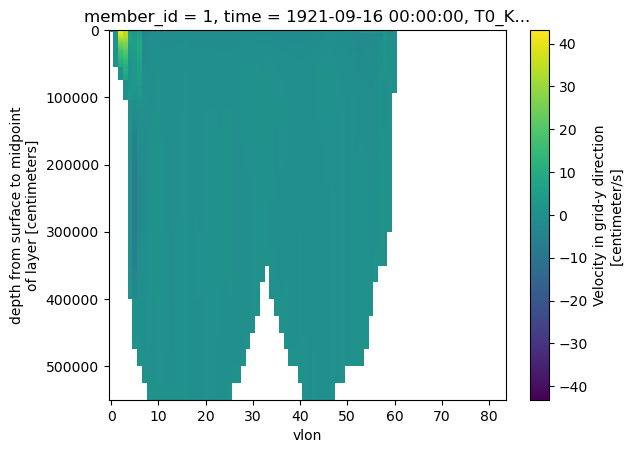

In [30]:
ds.VVEL.sel(vlat=latit).sel(member_id=pick_id).isel(vlon=slice(0,84)).isel(time=20).plot(cmap='viridis')
plt.gca().invert_yaxis()


In [31]:
v_write = ds.VVEL.sel(vlat=latit).sel(member_id=pick_id).isel(vlon=slice(0,84)).mean('time').to_dataset()
v_write = v_write.merge(thickness_above.mean('time').isel(nlon=slice(0,84)).rename('thickness'),compat='override')
v_write = v_write.merge(long_med.rename('median_long'))
v_write.load()
v_write.to_netcdf('/home/jovyan/amoc_heat_transport/26N_nocum/vel1.nc')

In [165]:
cluster.shutdown()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1389, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 206, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 698, in _handle_events
    self._ha